## Start Pyspark

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [2]:
start_spark(executor_instances=4, executor_cores=2, worker_memory=8, master_memory=8)

spark.dynamicAllocation.enabled,false
spark.sql.warehouse.dir,file:/users/home/spa296/spark-warehouse
spark.executor.instances,4
spark.app.startTime,1730080988414
spark.app.id,app-20241028150309-0009
spark.app.name,spa296 (jupyter)
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32


## Q1: Exploring the Datasets in HDFS

### (a) Overview of the Structure of the Datasets

In [3]:
!hdfs dfs -ls hdfs:///data/msd

Found 4 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/genre
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 hdfs:///data/msd/main
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile


In [4]:
!hdfs dfs -du -h /data/msd/

12.3 G   98.1 G   /data/msd/audio
30.1 M   241.0 M  /data/msd/genre
174.4 M  1.4 G    /data/msd/main
490.4 M  3.8 G    /data/msd/tasteprofile


#### 1. Genre Dataset

##### - Location:

In [5]:
!hdfs dfs -ls hdfs:///data/msd/genre

Found 3 items
-rwxr-xr-x   8 jsw93 supergroup   11625230 2021-09-29 10:35 hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv
-rwxr-xr-x   8 jsw93 supergroup    8820054 2021-09-29 10:35 hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv
-rwxr-xr-x   8 jsw93 supergroup   11140605 2021-09-29 10:35 hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv


#### - Size:

In [6]:
!hdfs dfs -du -h /data/msd/genre

11.1 M  88.7 M  /data/msd/genre/msd-MAGD-genreAssignment.tsv
8.4 M   67.3 M  /data/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  85.0 M  /data/msd/genre/msd-topMAGD-genreAssignment.tsv


#### - HDFS Details:

In [7]:
!hdfs fsck /data/msd/genre -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=spa296&files=1&blocks=1&locations=1&path=%2Fdata%2Fmsd%2Fgenre
FSCK started by spa296 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/genre at Mon Oct 28 15:03:19 NZDT 2024

/data/msd/genre <dir>
/data/msd/genre/msd-MAGD-genreAssignment.tsv 11625230 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761918_21096 len=11625230 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.126:9866,DS-6f3fc9d3-f21f-4098-9664-a781e15f486c,DISK], DatanodeInfoWithStorage[192.168.40.145:9866,DS-eb2f3e76-2e2c-4bb9-98ff-2eb86c531a80,DISK], DatanodeInfoWithStorage[192.168.40.116:9866,DS-49765458-974a-4728-a1a5-09ee775a1b0f,DISK], DatanodeInfoWithStorage[192.168.40.136:9866,DS-9d6d27e6-ba50-4de0-b616-5a345ab60e3b,DISK], DatanodeInfoWithStorage[192.168.40.183:9866,DS-d547a5f3-b56f-45ab-81b8-e9d492a4e1d3,DISK], DatanodeInfoWithStorage[192.168.40.159:9866,DS-93ea3ab4-4367-4d25-8560-df00f71281a3,DIS

#### 2. Audio Features Dataset

#### - Location:

In [8]:
!hdfs dfs -ls hdfs:///data/msd/audio

Found 3 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio/attributes
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/audio/features
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 hdfs:///data/msd/audio/statistics


#### - Size:

In [9]:
!hdfs dfs -du -h /data/msd/audio

103.0 K  824.3 K  /data/msd/audio/attributes
12.2 G   97.8 G   /data/msd/audio/features
40.3 M   322.1 M  /data/msd/audio/statistics


In [10]:
!hdfs dfs -du -h /data/msd/audio/attributes

1.0 K   8.2 K    /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
671     5.2 K    /data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
484     3.8 K    /data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
898     7.0 K    /data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
777     6.1 K    /data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
777     6.1 K    /data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
12.0 K  96.2 K   /data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
9.8 K   78.0 K   /data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
1.4 K   10.9 K   /data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
34.1 K  272.8 K  /data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
3.8 K   30.8 K   /data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
9.8 K   78.0 K   /data/msd/audio/attributes/msd-trh-v1.0.attributes.csv
27.6 K  221.2 

In [11]:
!hdfs dfs -du -h /data/msd/audio/features

65.5 M   524.2 M  /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   /data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    /data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   /data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    /data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   /data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G   /data/msd/audio/features/msd-tssd-v1.0.csv


In [12]:
!hdfs dfs -du -h /data/msd/audio/statistics

40.3 M  322.1 M  /data/msd/audio/statistics/sample_properties.csv.gz


#### - HDFS Details: 

In [13]:
!hdfs fsck /data/msd/audio/attributes -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=spa296&files=1&blocks=1&locations=1&path=%2Fdata%2Fmsd%2Faudio%2Fattributes
FSCK started by spa296 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/attributes at Mon Oct 28 15:03:29 NZDT 2024

/data/msd/audio/attributes <dir>
/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv 1051 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761895_21073 len=1051 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.126:9866,DS-6f3fc9d3-f21f-4098-9664-a781e15f486c,DISK], DatanodeInfoWithStorage[192.168.40.145:9866,DS-eb2f3e76-2e2c-4bb9-98ff-2eb86c531a80,DISK], DatanodeInfoWithStorage[192.168.40.141:9866,DS-6a225852-bdb2-4570-979e-f27bea4cf15a,DISK], DatanodeInfoWithStorage[192.168.40.176:9866,DS-33b48544-d8a1-496e-9dbf-3bc8c6e57d2c,DISK], DatanodeInfoWithStorage[192.168.40.158:9866,DS-60dfaa6a-f7a4-4d6c-8e44-70a79274b7af,DISK], DatanodeInfoWithStorage[192.1

In [14]:
!hdfs fsck /data/msd/audio/features -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=spa296&files=1&blocks=1&locations=1&path=%2Fdata%2Fmsd%2Faudio%2Ffeatures
FSCK started by spa296 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/features at Mon Oct 28 15:03:31 NZDT 2024

/data/msd/audio/features <dir>
/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv <dir>
/data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00000.csv.gz 8635110 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761769_20947 len=8635110 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.171:9866,DS-49f17978-db4c-4c3b-99ed-d63befd31a55,DISK], DatanodeInfoWithStorage[192.168.40.126:9866,DS-6f3fc9d3-f21f-4098-9664-a781e15f486c,DISK], DatanodeInfoWithStorage[192.168.40.159:9866,DS-93ea3ab4-4367-4d25-8560-df00f71281a3,DISK], DatanodeInfoWithStorage[192.168.40.134:9866,DS-0a049076-30db-4346-b90c-2e52cc905458,DISK], DatanodeInfoWithStorage[192.168.40.175:9866,DS

In [15]:
!hdfs fsck /data/msd/audio/statistics -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=spa296&files=1&blocks=1&locations=1&path=%2Fdata%2Fmsd%2Faudio%2Fstatistics
FSCK started by spa296 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/statistics at Mon Oct 28 15:03:33 NZDT 2024

/data/msd/audio/statistics <dir>
/data/msd/audio/statistics/sample_properties.csv.gz 42224669 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761717_20895 len=42224669 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.106:9866,DS-39db1648-d1af-450f-999c-277feea9beeb,DISK], DatanodeInfoWithStorage[192.168.40.174:9866,DS-6c8993c4-e39f-461c-9347-168db5ab8e83,DISK], DatanodeInfoWithStorage[192.168.40.134:9866,DS-0a049076-30db-4346-b90c-2e52cc905458,DISK], DatanodeInfoWithStorage[192.168.40.175:9866,DS-66d4decb-c161-4229-8cfd-888c915156db,DISK], DatanodeInfoWithStorage[192.168.40.128:9866,DS-42ca684a-77fe-4b8d-ae26-3b87bee447b2,DISK], DatanodeInfoWithStorage[192.168.40.118:9866,D

#### 3. Taste Profile Dataset

#### - Location:

In [16]:
!hdfs dfs -ls hdfs:///data/msd/tasteprofile/

Found 2 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/mismatches
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 hdfs:///data/msd/tasteprofile/triplets.tsv


#### - Size:

In [17]:
!hdfs dfs -du -h /data/msd/tasteprofile

2.0 M    16.2 M  /data/msd/tasteprofile/mismatches
488.4 M  3.8 G   /data/msd/tasteprofile/triplets.tsv


#### - HDFS Details:

In [18]:
!hdfs fsck /data/msd/tasteprofile -files -blocks -locations

Connecting to namenode via http://masternode2:9870/fsck?ugi=spa296&files=1&blocks=1&locations=1&path=%2Fdata%2Fmsd%2Ftasteprofile
FSCK started by spa296 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/tasteprofile at Mon Oct 28 15:03:38 NZDT 2024

/data/msd/tasteprofile <dir>
/data/msd/tasteprofile/mismatches <dir>
/data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt 91342 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761915_21093 len=91342 Live_repl=8  [DatanodeInfoWithStorage[192.168.40.106:9866,DS-39db1648-d1af-450f-999c-277feea9beeb,DISK], DatanodeInfoWithStorage[192.168.40.174:9866,DS-6c8993c4-e39f-461c-9347-168db5ab8e83,DISK], DatanodeInfoWithStorage[192.168.40.183:9866,DS-d547a5f3-b56f-45ab-81b8-e9d492a4e1d3,DISK], DatanodeInfoWithStorage[192.168.40.158:9866,DS-60dfaa6a-f7a4-4d6c-8e44-70a79274b7af,DISK], DatanodeInfoWithStorage[192.168.40.146:9866,DS-78e0658d-eb04-4ecc-a5e9-d938d37304b4,DISK], DatanodeI

### (b) Load Different Types of Datasets

#### - Loading Genre Dataset (TSV Format)

In [19]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("track_id", StringType(), nullable=False),
    StructField("genre", StringType(), nullable=False)
])

# Read TSV file from HDFS with schema
hdfs_path = "hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv"
genre_df = spark.read.option("delimiter", "\t").schema(schema).csv(hdfs_path)

# Show the DataFrame
show_as_html(genre_df)

,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock
5,TRAAADT12903CCC339,Easy_Listening
6,TRAAAED128E0783FAB,Vocal
7,TRAAAEF128F4273421,Pop_Rock
8,TRAAAEM128F93347B9,Electronic
9,TRAAAFD128F92F423A,Pop_Rock


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

# Initialize Spark session (ensure it is running)
spark = SparkSession.builder.appName("MSD_Genre_Distribution").getOrCreate()

# Load the MSD Allmusic Genre Dataset (MAGD)
hdfs_path = "hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv"
magd = spark.read.option("delimiter", "\t").option("header", "false").csv(hdfs_path)

# Count occurrences of each genre
genre_count = magd.groupBy(col("_c1").alias("genre")).agg(count("*").alias("genre_count"))

# Show the result as an HTML table (you may need a helper function to display)
show_as_html(genre_count)

,genre,genre_count
0,Vocal,6195
1,Religious,8814
2,Blues,6836
3,Children,477
4,Classical,556
5,New Age,4010
6,Reggae,6946
7,Holiday,200
8,Stage,1614
9,Easy_Listening,1545


#### - Loading Audio Features Dataset (CSV Format)

In [21]:
# Define the path for audio features data
audio_features_path = "hdfs:///data/msd/audio/attributes/"

# Load the audio attributes dataset from HDFS without header and with schema inference
audio_attributes_data = (
    spark.read.option("header", "false")
    .option("inferSchema", "true")
    .csv(audio_features_path + "*.csv")
)

# Display the loaded data as an HTML table
show_as_html(audio_attributes_data)

# Count the number of rows in the audio attributes dataset
attributes_row_count = audio_attributes_data.count()

# Print the total row count of the dataset
print(f"Total rows in audio attributes dataset: {attributes_row_count}")

,_c0,_c1
0,component_1,NUMERIC
1,component_2,NUMERIC
2,component_3,NUMERIC
3,component_4,NUMERIC
4,component_5,NUMERIC
5,component_6,NUMERIC
6,component_7,NUMERIC
7,component_8,NUMERIC
8,component_9,NUMERIC
9,component_10,NUMERIC


Total rows in audio attributes dataset: 3929


In [22]:
# Load the audio features dataset from HDFS without header and inferring schema
audio_features_path = "hdfs:///data/msd/audio/features/"

# Load the dataset using CSV format
audio_features_df = (
    spark.read.option("header", "false")
    .option("inferSchema", "true")
    .csv(audio_features_path + "*.csv")
)

# Display the audio features DataFrame as an HTML table
show_as_html(audio_features_df)

# Count the total number of rows in the audio features dataset
audio_row_count = audio_features_df.count()

# Print the row count
print(f"Total number of rows in audio features dataset: {audio_row_count}")

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c1431,_c1432,_c1433,_c1434,_c1435,_c1436,_c1437,_c1438,_c1439,_c1440
0,0.002736,0.003725,0.007415,0.002806,0.008469,0.007994,0.014948,0.008144,0.011970,0.013622,...,0.026226,0.017471,0.004238,0.009438,0.004225,0.005165,0.005210,0.003043,0.000001,TRYWDAH128F92D4539
1,0.001376,0.012098,0.004903,0.009153,0.009236,0.005353,0.003515,0.005018,0.006722,0.006616,...,0.007779,0.013003,0.012642,0.009386,0.005285,0.003885,0.002716,0.000712,0.000001,TRJVUJL128C71968F1
2,0.006036,0.006173,0.00735,0.008331,0.007874,0.008664,0.007132,0.008543,0.006113,0.007539,...,0.027203,0.022541,0.016961,0.027418,0.021692,0.017372,0.019103,0.011734,0.000001,TRIDGZT128F428B9F5
3,0.018246,0.008646,0.021885,0.041223,0.004092,0.080736,0.041131,0.051823,0.020586,0.033808,...,0.009745,0.006665,0.010780,0.003438,0.003464,0.003668,0.004031,0.001271,0.000001,TRHNLNG128F42717FF
4,0.01251,0.018594,0.027447,0.036388,0.023727,0.038141,0.031223,0.038639,0.025802,0.022678,...,0.060113,0.062213,0.075493,0.061272,0.025676,0.020332,0.020932,0.011308,0.002284,TRCNVJH128F427213A
5,0.015173,0.024388,0.017414,0.014775,0.009949,0.007749,0.013393,0.019128,0.033999,0.025982,...,0.027453,0.017317,0.033406,0.022561,0.006079,0.007488,0.002610,0.002452,0.000001,TRKBNOF12903C9A1D0
6,0.030123,0.029823,0.017036,0.010914,0.009533,0.033847,0.046585,0.045769,0.032532,0.028118,...,0.039497,0.046678,0.021754,0.019527,0.028064,0.025103,0.014041,0.005553,0.000001,TRRKOTO128F427F068
7,0.012157,0.028668,0.031598,0.041904,0.025031,0.037941,0.010480,0.016895,0.014114,0.011265,...,0.014447,0.008175,0.012875,0.006476,0.012686,0.004745,0.002044,0.001856,0.000024,TRSXPJU128F429B580
8,0.005166,0.009210,0.020146,0.012968,0.034602,0.031521,0.028261,0.027158,0.031296,0.022515,...,0.057038,0.061210,0.056427,0.040610,0.039139,0.049079,0.035069,0.017533,0.000001,TRFQFHW128F9334372
9,0.011165,0.015923,0.019574,0.009199,0.020257,0.022547,0.024160,0.022785,0.020751,0.021249,...,0.040683,0.033287,0.021351,0.022602,0.012404,0.012053,0.007244,0.002445,0.000001,TRQPSBI128F14AFB5A


Total number of rows in audio features dataset: 12927867


In [23]:
# Specify the path for the audio statistics data
audio_stats_path = "hdfs:///data/msd/audio/statistics/"

# Load the audio statistics dataset in CSV format from HDFS with headers
audio_stats_df = (
    spark.read.option("header", "true")
    .csv(audio_stats_path + "*.csv.gz")
)

# Display the DataFrame content as an HTML table
show_as_html(audio_stats_df)

# Count the number of rows in the audio statistics DataFrame
total_rows_audio_stats = audio_stats_df.count()

# Output the row count
print(f"Total number of rows in the audio statistics dataset: {total_rows_audio_stats}")

,track_id,title,artist_name,duration,7digita_Id,sample_bitrate,sample_length,sample_rate,sample_mode,sample_version,filesize
0,TRMMMYQ128F932D901,Silent Night,Faster Pussy cat,252.05506,7032331,128,60.1935770567,22050,1,2,960887
1,TRMMMKD128F425225D,Tanssi vaan,Karkkiautomaatti,156.55138,1514808,64,30.2244270016,22050,1,2,242038
2,TRMMMRX128F93187D9,No One Could Ever,Hudson Mohawke,138.97098,6945353,128,60.1935770567,22050,1,2,960887
3,TRMMMCH128F425532C,Si Vos Querés,Yerba Brava,145.05751,2168257,64,30.2083516484,22050,1,2,240534
4,TRMMMWA128F426B589,Tangle Of Aspens,Der Mystic,514.29832,2264873,64,60.3382103611,22050,1,2,480443
5,TRMMMXN128F42936A5,"""Symphony No. 1 G minor """"Sinfonie Serieuse""""/...",David Montgomery,816.53506,3360982,128,30.1360348456,44100,0,1,481070
6,TRMMMLR128F1494097,We Have Got Love,Sasha / Turbulence,212.37506,552626,64,60.3542857143,22050,1,2,480686
7,TRMMMBB12903CB7D21,2 Da Beat Ch'yall,Kris Kross,221.20444,6435649,128,30.1360348456,44100,0,1,481070
8,TRMMMHY12903CB53F1,Goodbye,Joseph Locke,139.17995,8376489,128,60.2459472422,22050,1,2,961723
9,TRMMMML128F4280EE9,Mama_ mama can't you see ?,The Sun Harbor's Chorus-Documentary Recordings,104.48934,1043208,206,30.0408163265,44100,1,1,777413


Total number of rows in the audio statistics dataset: 992865


#### - Loading Taste Profile Dataset (TSV Format)

In [24]:
# Specify the path for the taste profile dataset in HDFS
taste_profile_path = "hdfs:///data/msd/tasteprofile/"

# Load the taste profile dataset in TSV format from HDFS, using tab as the delimiter
taste_profile_df = (
    spark.read.option("delimiter", "\t")
    .option("header", "false")
    .csv(taste_profile_path + "*.tsv")
)

# Display the loaded DataFrame in HTML format
show_as_html(taste_profile_df)

# Count the total number of rows in the taste profile dataset
total_rows_taste_profile = taste_profile_df.count()

# Output the row count
print(f"Total number of rows in the taste profile dataset: {total_rows_taste_profile}")

,_c0,_c1,_c2
0,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQEFDN12AB017C52B,1
1,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQOIUJ12A6701DAA7,2
2,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQOKKD12A6701F92E,4
3,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSDVHO12AB01882C7,1
4,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSKICX12A6701F932,1
5,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSNUPV12A8C13939B,1
6,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSVMII12A6701F92D,1
7,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTUNHI12B0B80AFE2,1
8,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTXLTZ12AB017C535,1
9,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTZDDX12A6701F935,1


Total number of rows in the taste profile dataset: 48373586


### (c) Count the Number of Rows in Each Dataset

#### - Counting Rows in Genre Dataset

In [25]:
# Path to the genre dataset in HDFS
genre_path = "hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv"

# Load the genre dataset with inferred schema
genre_df = (
    spark.read.option("delimiter", "\t")
    .option("header", "false")
    .csv(genre_path)
)

# Count the number of rows in the genre dataset
total_rows_genre = genre_df.count()

# Output the result
print(f"Total number of rows in the genre dataset: {total_rows_genre}")

Total number of rows in the genre dataset: 422714


#### - Counting Rows in Audio Features Dataset

In [26]:
# Path to the audio features dataset in HDFS
audio_features_path = "hdfs:///data/msd/audio/features/"

# Load the audio features dataset
audio_features_df = (
    spark.read.option("header", "false")
    .option("inferSchema", "true")
    .csv(audio_features_path + "*.csv")
)

# Count the number of rows in the audio features dataset
total_rows_audio = audio_features_df.count()

# Output the result
print(f"Total number of rows in the audio features dataset: {total_rows_audio}")

Total number of rows in the audio features dataset: 12927867


#### - Counting Rows in Taste Profile Dataset

In [27]:
# Path to the taste profile dataset in HDFS
taste_profile_path = "hdfs:///data/msd/tasteprofile/"

# Load the taste profile dataset in TSV format
taste_profile_df = (
    spark.read.option("delimiter", "\t")
    .option("header", "false")
    .csv(taste_profile_path + "*.tsv")
)

# Count the number of rows in the taste profile dataset
total_rows_taste_profile = taste_profile_df.count()

# Output the result
print(f"Total number of rows in the taste profile dataset: {total_rows_taste_profile}")

Total number of rows in the taste profile dataset: 48373586


#### Counting Unique Songs

In [28]:
# Counting unique songs in the genre dataset (based on track ID in the first column)
unique_songs_genre = genre_df.select("_c0").distinct().count()
print(f"Total number of unique songs in the genre dataset: {unique_songs_genre}")

# Counting unique songs in the audio features dataset (assuming the track ID is in the first column)
unique_songs_audio = audio_features_df.select("_c0").distinct().count()
print(f"Total number of unique songs in the audio features dataset: {unique_songs_audio}")

# Counting unique songs in the taste profile dataset (assuming the track ID is in the first column)
unique_songs_taste_profile = taste_profile_df.select("_c0").distinct().count()
print(f"Total number of unique songs in the taste profile dataset: {unique_songs_taste_profile}")

Total number of unique songs in the genre dataset: 422714
Total number of unique songs in the audio features dataset: 3383455
Total number of unique songs in the taste profile dataset: 1019318


In [29]:
# Comparison of total rows and unique songs for each dataset

# Compare for Genre Dataset
print(f"\nGenre Dataset - Total Rows: {total_rows_genre}, Unique Songs: {unique_songs_genre}")
print(f"Difference in Genre Dataset: {total_rows_genre - unique_songs_genre}")

# Compare for Audio Features Dataset
print(f"\nAudio Features Dataset - Total Rows: {total_rows_audio}, Unique Songs: {unique_songs_audio}")
print(f"Difference in Audio Features Dataset: {total_rows_audio - unique_songs_audio}")

# Compare for Taste Profile Dataset
print(f"\nTaste Profile Dataset - Total Rows: {total_rows_taste_profile}, Unique Songs: {unique_songs_taste_profile}")
print(f"Difference in Taste Profile Dataset: {total_rows_taste_profile - unique_songs_taste_profile}")

# Summary of unique songs across all datasets
print(f"\nSummary of Unique Songs:")
print(f"Unique Songs in Genre Dataset: {unique_songs_genre}")
print(f"Unique Songs in Audio Features Dataset: {unique_songs_audio}")
print(f"Unique Songs in Taste Profile Dataset: {unique_songs_taste_profile}")



Genre Dataset - Total Rows: 422714, Unique Songs: 422714
Difference in Genre Dataset: 0

Audio Features Dataset - Total Rows: 12927867, Unique Songs: 3383455
Difference in Audio Features Dataset: 9544412

Taste Profile Dataset - Total Rows: 48373586, Unique Songs: 1019318
Difference in Taste Profile Dataset: 47354268

Summary of Unique Songs:
Unique Songs in Genre Dataset: 422714
Unique Songs in Audio Features Dataset: 3383455
Unique Songs in Taste Profile Dataset: 1019318


## Q2: Data preprocessing

### (a) Load the Audio Feature Attribute Names and Types

In [30]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Define a function to map attribute types to PySpark SQL types
def map_attribute_type(attr_type):
    if attr_type == "NUMERIC":
        return DoubleType()
    elif attr_type == "STRING":
        return StringType()
    else:
        return StringType()  # Default to StringType if unknown

# Load the audio attribute dataset (assuming a CSV format)
attributes_path = "hdfs:///data/msd/audio/attributes/*.csv"
attributes_df = spark.read.option("header", "false").csv(attributes_path)

# Extract column names and types from the attribute files
attribute_names_types = attributes_df.collect()  # Assuming each row has name and type

# Automatically generate a StructType schema based on attribute types
audio_schema = StructType([
    StructField(row[0], map_attribute_type(row[1]), nullable=True)
    for row in attribute_names_types
])

# Print the generated schema
print("Generated Audio Feature Schema:")
print(audio_schema)

Generated Audio Feature Schema:
StructType(List(StructField(component_1,DoubleType,true),StructField(component_2,DoubleType,true),StructField(component_3,DoubleType,true),StructField(component_4,DoubleType,true),StructField(component_5,DoubleType,true),StructField(component_6,DoubleType,true),StructField(component_7,DoubleType,true),StructField(component_8,DoubleType,true),StructField(component_9,DoubleType,true),StructField(component_10,DoubleType,true),StructField(component_11,DoubleType,true),StructField(component_12,DoubleType,true),StructField(component_13,DoubleType,true),StructField(component_14,DoubleType,true),StructField(component_15,DoubleType,true),StructField(component_16,DoubleType,true),StructField(component_17,DoubleType,true),StructField(component_18,DoubleType,true),StructField(component_19,DoubleType,true),StructField(component_20,DoubleType,true),StructField(component_21,DoubleType,true),StructField(component_22,DoubleType,true),StructField(component_23,DoubleType,t

### (b) Load One or More of the Audio Feature Attribute Datasets

In [31]:
from pyspark.sql.types import DoubleType, StringType, StructType, StructField

# List of audio feature dataset names
audio_dataset_list = [
    "msd-jmir-area-of-moments-all-v1.0",
    "msd-jmir-lpc-all-v1.0",
    "msd-jmir-methods-of-moments-all-v1.0",
    "msd-jmir-mfcc-all-v1.0",
    "msd-jmir-spectral-all-all-v1.0",
    "msd-jmir-spectral-derivatives-all-all-v1.0",
    "msd-marsyas-timbral-v1.0",
    "msd-mvd-v1.0",
    "msd-rh-v1.0",
    "msd-rp-v1.0",
    "msd-ssd-v1.0",
    "msd-trh-v1.0",
    "msd-tssd-v1.0"
]

# Mapping to handle the data types in attribute files
data_type_map = {
    "real": DoubleType(),
    "NUMERIC": DoubleType(),
    "float": DoubleType(),
    "string": StringType(),
    "STRING": StringType()
}

# List to store dataset info (name, path, schema)
prepared_datasets = []

# Loop through the dataset list to process each one
for dataset in audio_dataset_list:
    attr_file_path = f'/data/msd/audio/attributes/{dataset}.attributes.csv'
    feature_file_path = f'/data/msd/audio/features/{dataset}.csv'

    # Load attribute file to extract column names and types
    attr_data = spark.read.csv(attr_file_path).toPandas()

    # Dynamically create schema based on attribute file
    dataset_schema = StructType([
        StructField(row[0], data_type_map.get(row[1], StringType()), True) 
        for _, row in attr_data.iterrows()
    ])
    
    # Add dataset details to the list
    prepared_datasets.append((dataset, feature_file_path, dataset_schema))

# Output the datasets with their schemas
for dataset_name, file_path, schema in prepared_datasets:
    print(f"Dataset Name: {dataset_name}, File Path: {file_path}, Schema: {schema}")

Dataset Name: msd-jmir-area-of-moments-all-v1.0, File Path: /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv, Schema: StructType(List(StructField(Area_Method_of_Moments_Overall_Standard_Deviation_1,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_2,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_3,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_4,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_5,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_6,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_7,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_8,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_9,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_10,DoubleType,true),StructField(Area_Method_of_Moments_Overal

In [32]:
# Load one or more audio feature datasets using the schema

for dataset_name, feature_file_path, dataset_schema in prepared_datasets:
    print(f"Loading dataset: {dataset_name}")

    # Load the audio feature dataset with the generated schema
    audio_features_df = spark.read.csv(feature_file_path, schema=dataset_schema, header=False)

    # Show the first few rows to verify the dataset has been loaded correctly
    print(f"First few rows of {dataset_name}:")
    audio_features_df.show(5)

Loading dataset: msd-jmir-area-of-moments-all-v1.0
First few rows of msd-jmir-area-of-moments-all-v1.0:
+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----

### Part (c): Renaming Audio Feature Columns for Convenience

In [33]:
from pyspark.sql.functions import col

# Function to systematically rename columns in a simple sequential format
def rename_columns_simple(df):
    """
    Renames columns to a simpler format like 'feature_1', 'feature_2', etc.

    Parameters:
    df (DataFrame): The DataFrame whose columns need to be renamed.

    Returns:
    DataFrame: DataFrame with renamed columns.
    """
    # Create a dictionary to map old column names to 'feature_1', 'feature_2', etc.
    new_column_names = {old_name: f"feature_{i+1}" for i, old_name in enumerate(df.columns)}

    # Rename the columns in the DataFrame
    renamed_df = df.select([col(c).alias(new_column_names[c]) for c in df.columns])
    
    return renamed_df

# Function to display the renamed DataFrame as an HTML table with a title
def show_dataset_as_html(dataset_name, df):
    """
    Displays a DataFrame as an HTML table with a title.

    Parameters:
    dataset_name (str): The title to display above the table.
    df (DataFrame): The DataFrame to display.
    """
    print(f"Dataset: {dataset_name}")  # This will act as the title
    show_as_html(df)  # Display the DataFrame as an HTML table

# Apply the renaming function to the loaded dataset and display as HTML
for dataset_name, feature_file_path, dataset_schema in prepared_datasets:
    print(f"Processing dataset: {dataset_name}")
    
    # Load the audio feature dataset using the schema
    audio_features_df = spark.read.csv(feature_file_path, schema=dataset_schema, header=False)
    
    # Rename the columns in a simple format
    renamed_audio_features_df = rename_columns_simple(audio_features_df)
    
    # Display the renamed DataFrame as an HTML table with a title
    show_dataset_as_html(f"Renamed Audio Features - {dataset_name}", renamed_audio_features_df.limit(5))


Processing dataset: msd-jmir-area-of-moments-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-area-of-moments-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,5746.0,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,'TRHFHQZ12903C9E2D5'
1,0.9295,6720.0,44100.0,160800000.0,1.060000e+09,6.985000e+09,7.095000e+12,9.545000e+09,6.293000e+10,2.037000e+15,...,11580.0,74040.0,-179200000.0,-1.153000e+09,-7.420000e+09,6.242000e+12,1.037000e+10,6.680000e+10,1.694000e+15,'TRHFHYX12903CAF953'
2,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,11580.0,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,'TRHFHAU128F9341A0E'
3,1.8840,6722.0,56130.0,161000000.0,1.346000e+09,1.127000e+10,7.112000e+12,1.211000e+10,1.014000e+11,4.193000e+15,...,11600.0,93320.0,-179700000.0,-1.459000e+09,-1.185000e+10,6.262000e+12,1.311000e+10,1.066000e+11,3.432000e+15,'TRHFHLP128F14947A7'
4,1.5200,6709.0,53230.0,160500000.0,1.295000e+09,1.045000e+10,7.076000e+12,1.164000e+10,9.392000e+10,3.751000e+15,...,11580.0,93650.0,-179000000.0,-1.441000e+09,-1.159000e+10,6.230000e+12,1.293000e+10,1.041000e+11,3.248000e+15,'TRHFHFF128F930AC11'


Processing dataset: msd-jmir-lpc-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-lpc-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21
0,0.04652,0.1125,0.1386,0.18290,0.09227,0.1261,0.06775,0.11680,0.08311,0.0,...,0.6449,-0.03497,-0.17800,-0.27790,0.10960,-0.140400,0.02397,-0.12520,0.0,'TRMMMYQ128F932D901'
1,0.05153,0.1267,0.1630,0.15280,0.11270,0.1794,0.07344,0.08478,0.06295,0.0,...,0.7336,0.11510,-0.21120,-0.23690,0.14430,-0.081700,-0.01350,-0.13160,0.0,'TRMMMKD128F425225D'
2,0.04112,0.1182,0.1352,0.09433,0.14480,0.1185,0.10710,0.08826,0.12590,0.0,...,0.3939,-0.24540,-0.08293,-0.32000,0.11670,-0.087040,-0.10010,-0.14580,0.0,'TRMMMRX128F93187D9'
3,0.08796,0.1409,0.1781,0.13080,0.15690,0.1263,0.12650,0.10070,0.10500,0.0,...,0.4590,-0.25060,0.01747,-0.28360,0.21950,-0.055110,-0.02631,-0.09313,0.0,'TRMMMCH128F425532C'
4,0.02573,0.1512,0.1432,0.14310,0.10650,0.1196,0.07276,0.08836,0.05992,0.0,...,0.6478,0.09408,0.06476,-0.01578,0.06642,0.004455,-0.01168,-0.03808,0.0,'TRMMMWA128F426B589'


Processing dataset: msd-jmir-methods-of-moments-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-methods-of-moments-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,0.1545,13.110,840.0,41080.0,7108000.0,0.3190,33.41,1371.0,64240.0,8398000.0,'TRHFHQZ12903C9E2D5'
1,0.1195,13.020,611.9,43880.0,7226000.0,0.2661,30.26,1829.0,183800.0,31230000.0,'TRHFHYX12903CAF953'
2,0.2326,7.185,362.2,19890.0,3030000.0,0.8854,32.68,1384.0,79190.0,9862000.0,'TRHFHAU128F9341A0E'
3,0.2283,10.300,463.8,24730.0,3336000.0,0.4321,37.56,2047.0,197200.0,32930000.0,'TRHFHLP128F14947A7'
4,0.1841,8.544,359.4,21900.0,3359000.0,0.8438,36.36,2008.0,205400.0,35390000.0,'TRHFHFF128F930AC11'


Processing dataset: msd-jmir-mfcc-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-mfcc-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27
0,59.28,4.150,5.105,2.275,2.185,1.950,1.603,1.335,1.300,1.396,...,1.0330,-0.3445,-0.4305,0.1372,0.0312,-0.3132,-0.0815,0.72130,-0.40500,'TRHFHQZ12903C9E2D5'
1,46.35,6.888,4.652,4.131,3.225,2.826,2.108,1.922,1.950,1.697,...,-0.2149,3.7400,0.2908,1.9200,0.1250,1.2420,-0.5187,0.25480,-0.40730,'TRHFHYX12903CAF953'
2,38.63,3.041,2.504,2.141,1.853,1.906,1.867,1.547,1.491,1.468,...,1.0350,1.2830,1.4080,0.5908,0.4882,0.5522,-0.3168,-0.58870,0.03743,'TRHFHAU128F9341A0E'
3,33.49,5.009,4.560,3.153,2.383,2.400,2.113,1.985,2.075,1.827,...,-1.3510,2.2640,-0.2145,0.3408,-0.6040,1.2610,-1.5270,0.02701,-0.73340,'TRHFHLP128F14947A7'
4,37.43,4.107,3.167,2.793,2.158,1.926,1.814,1.598,1.622,1.547,...,-1.0630,1.1670,0.0559,1.6820,-0.6607,1.0380,-0.1167,0.46200,-0.36870,'TRHFHFF128F930AC11'


Processing dataset: msd-jmir-spectral-all-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-spectral-all-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,7.928,0.07893,0.001245,222.2,0.001429,0.05438,0.05324,22.35,12.810,0.09207,0.000914,1682.0,0.003026,0.1199,0.5313,38.15,'TRHFHQZ12903C9E2D5'
1,8.501,0.07007,0.005855,200.6,0.003042,0.09163,0.05096,21.18,7.432,0.05245,0.003384,1570.0,0.004289,0.1532,0.5988,25.07,'TRHFHYX12903CAF953'
2,5.101,0.04946,0.007952,241.3,0.002879,0.08716,0.03366,13.13,9.995,0.07575,0.010310,1455.0,0.008896,0.3404,0.5227,34.82,'TRHFHAU128F9341A0E'
3,8.101,0.06402,0.002458,238.5,0.002335,0.08902,0.06764,18.71,15.350,0.10200,0.001901,1712.0,0.004152,0.1649,0.5467,41.47,'TRHFHLP128F14947A7'
4,7.226,0.05985,0.005215,194.7,0.002057,0.05784,0.04056,15.88,12.980,0.10940,0.008331,1595.0,0.008042,0.3087,0.5067,39.75,'TRHFHFF128F930AC11'


Processing dataset: msd-jmir-spectral-derivatives-all-all-v1.0
Dataset: Renamed Audio Features - msd-jmir-spectral-derivatives-all-all-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
0,7.928,0.07893,0.001245,222.2,0.001429,0.05438,0.05324,22.35,12.810,0.09207,0.000914,1682.0,0.003026,0.1199,0.5313,38.15,'TRHFHQZ12903C9E2D5'
1,8.501,0.07007,0.005855,200.6,0.003042,0.09163,0.05096,21.18,7.432,0.05245,0.003384,1570.0,0.004289,0.1532,0.5988,25.07,'TRHFHYX12903CAF953'
2,5.101,0.04946,0.007952,241.3,0.002879,0.08716,0.03366,13.13,9.995,0.07575,0.010310,1455.0,0.008896,0.3404,0.5227,34.82,'TRHFHAU128F9341A0E'
3,8.101,0.06402,0.002458,238.5,0.002335,0.08902,0.06764,18.71,15.350,0.10200,0.001901,1712.0,0.004152,0.1649,0.5467,41.47,'TRHFHLP128F14947A7'
4,7.226,0.05985,0.005215,194.7,0.002057,0.05784,0.04056,15.88,12.980,0.10940,0.008331,1595.0,0.008042,0.3087,0.5067,39.75,'TRHFHFF128F930AC11'


Processing dataset: msd-marsyas-timbral-v1.0
Dataset: Renamed Audio Features - msd-marsyas-timbral-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125
0,0.112178,0.088561,0.210064,0.094495,-43.977376,3.548018,0.346619,0.580689,-0.226928,0.218630,...,0.000976,0.001009,0.001089,0.001077,0.001037,0.000982,0.001076,0.277586,20.106226,TRSUFWB128F4255BAE
1,0.133675,0.100968,0.229477,0.087755,-42.694424,3.856577,-0.623697,0.510768,0.157851,-0.191616,...,0.000490,0.000480,0.000506,0.000496,0.000461,0.000448,0.000425,0.256402,2.877227,TRSUFSW128F4284B04
2,0.198948,0.177070,0.292963,0.087348,-38.523920,0.690861,-2.264458,1.314971,0.207455,0.143965,...,0.000351,0.000282,0.000288,0.000292,0.000281,0.000289,0.000375,0.080737,0.524488,TRSUFUP128F42561A2
3,0.086491,0.061144,0.132627,0.094506,-43.728943,3.964348,0.943620,1.687271,0.441880,0.541842,...,0.001156,0.001039,0.000951,0.000896,0.000822,0.000770,0.000847,0.277738,7.509386,TRSUFWL128F42956C9
4,0.170560,0.206775,0.451917,0.108458,-62.959637,1.115836,0.030579,-0.110063,-0.177790,0.222752,...,0.001632,0.001724,0.001587,0.001472,0.001094,0.001588,0.001523,0.512680,80.313907,TRSUFQR12903CD493C


Processing dataset: msd-mvd-v1.0
Dataset: Renamed Audio Features - msd-mvd-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421
0,0.226884,0.230364,0.219057,0.175083,0.169087,0.168407,0.138525,0.124724,0.152904,0.123112,...,0.146509,0.147567,0.121105,0.132596,0.144324,0.116596,0.168728,0.157645,0.110822,'TRYWDAH128F92D4539'
1,0.214838,0.181556,0.107927,0.110481,0.120849,0.104712,0.086065,0.068917,0.091953,0.073461,...,0.080255,0.087641,0.098576,0.077290,0.089487,0.068734,0.103242,0.091347,0.073943,'TRJVUJL128C71968F1'
2,0.599207,0.462929,0.334623,0.235651,0.180505,0.192023,0.162616,0.147555,0.147512,0.150728,...,0.131198,0.137329,0.117605,0.111755,0.113637,0.101259,0.091637,0.107954,0.094497,'TRHNLNG128F42717FF'
3,0.161975,0.131392,0.147728,0.146141,0.125190,0.131663,0.127299,0.124623,0.098403,0.161160,...,0.145621,0.153424,0.137743,0.090890,0.105781,0.121976,0.122234,0.114681,0.122273,'TRIDGZT128F428B9F5'
4,0.511186,0.445876,0.395141,0.328717,0.297649,0.205640,0.260945,0.189948,0.317763,0.215753,...,0.172113,0.161366,0.159870,0.176630,0.197752,0.165474,0.149154,0.173748,0.259310,'TRCNVJH128F427213A'


Processing dataset: msd-rh-v1.0
Dataset: Renamed Audio Features - msd-rh-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61
0,5.965746,5.633224,5.295259,4.188206,4.023376,3.515610,3.344197,3.339900,3.610377,3.100263,...,1.176926,1.383768,1.196357,1.123239,1.292873,1.178216,1.002451,1.203526,0.907604,'TRYWDAH128F92D4539'
1,4.853912,3.913811,2.286072,2.583405,2.823458,2.354543,2.086963,1.679639,2.226083,1.931475,...,0.695435,0.759757,0.835221,0.742432,0.689854,0.628478,0.722130,0.666933,0.678972,'TRJVUJL128C71968F1'
2,3.923767,2.956465,3.671716,3.083990,2.879255,2.786314,3.120237,2.632083,2.083783,4.158884,...,1.129439,1.191363,1.285582,0.884632,0.889719,1.008565,1.051691,0.944400,1.303650,'TRIDGZT128F428B9F5'
3,13.195897,10.883453,8.830368,6.359973,4.522331,4.368110,3.778535,3.662791,3.603957,3.935505,...,0.945969,0.957197,0.878725,0.957463,0.968238,0.817337,0.753092,0.860108,0.817529,'TRHNLNG128F42717FF'
4,13.785449,10.229630,8.138473,7.748904,7.104238,4.991848,6.260711,4.912233,7.589170,4.993329,...,1.901360,1.805084,1.580570,1.646917,2.346912,1.528140,1.835398,1.661893,2.697921,'TRCNVJH128F427213A'


Processing dataset: msd-rp-v1.0
Dataset: Renamed Audio Features - msd-rp-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1432,feature_1433,feature_1434,feature_1435,feature_1436,feature_1437,feature_1438,feature_1439,feature_1440,feature_1441
0,0.002736,0.003725,0.007415,0.002806,0.008469,0.007994,0.014948,0.008144,0.011970,0.013622,...,0.026226,0.017471,0.004238,0.009438,0.004225,0.005165,0.005210,0.003043,0.000001,TRYWDAH128F92D4539
1,0.001376,0.012098,0.004903,0.009153,0.009236,0.005353,0.003515,0.005018,0.006722,0.006616,...,0.007779,0.013003,0.012642,0.009386,0.005285,0.003885,0.002716,0.000712,0.000001,TRJVUJL128C71968F1
2,0.006036,0.006173,0.007350,0.008331,0.007874,0.008664,0.007132,0.008543,0.006113,0.007539,...,0.027203,0.022541,0.016961,0.027418,0.021692,0.017372,0.019103,0.011734,0.000001,TRIDGZT128F428B9F5
3,0.018246,0.008646,0.021885,0.041223,0.004092,0.080736,0.041131,0.051823,0.020586,0.033808,...,0.009745,0.006665,0.010780,0.003438,0.003464,0.003668,0.004031,0.001271,0.000001,TRHNLNG128F42717FF
4,0.012510,0.018594,0.027447,0.036388,0.023727,0.038141,0.031223,0.038639,0.025802,0.022678,...,0.060113,0.062213,0.075493,0.061272,0.025676,0.020332,0.020932,0.011308,0.002284,TRCNVJH128F427213A


Processing dataset: msd-ssd-v1.0
Dataset: Renamed Audio Features - msd-ssd-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169
0,3.340253,3.184129,3.467989,3.961744,3.802365,4.048197,3.617043,3.335274,3.111133,2.560841,...,9.814441,12.419846,9.361515,7.508801,6.970781,4.840366,4.327801,2.079462,0.001066,'TRJAPJV128F147E501'
1,3.859655,3.169665,2.339668,2.379815,2.087785,3.719538,3.033265,2.719684,2.258551,2.830153,...,9.991244,7.845734,8.712100,4.766188,3.607995,3.487868,2.994789,1.304786,0.001066,'TRKXUVI12903CF164C'
2,2.366181,3.693143,3.689352,3.922064,3.597496,3.675475,3.366070,3.149710,2.901223,2.544667,...,12.181783,9.146891,7.610539,6.840762,5.609022,4.445043,3.850136,2.175525,0.412306,'TRVSMHB128F933868B'
3,2.049054,4.118874,3.839635,3.426112,2.437866,2.808449,2.486959,2.366762,2.135613,1.633703,...,6.914300,7.312521,6.697511,6.286495,5.046462,3.163909,2.540429,1.371564,0.001066,'TRIIFIJ128F425D096'
4,4.407492,4.824841,4.080729,4.589847,3.908415,3.944584,4.569623,4.178122,4.202005,3.411257,...,18.883988,18.684402,12.268226,9.667586,7.543367,9.391542,11.664551,6.619618,1.100809,'TRKKTRL128F933DE30'


Processing dataset: msd-trh-v1.0
Dataset: Renamed Audio Features - msd-trh-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421
0,7.663735,6.981061,8.467507,6.571336,5.633960,8.180509,4.314876,4.100904,5.979875,3.670057,...,2.095989,1.726187,2.308420,2.044628,1.671321,2.294742,1.787176,1.507227,2.970258,'TRBRYCM128F42681FE'
1,17.145029,13.643089,10.666042,8.857338,8.446842,10.066524,6.726110,6.230044,6.250445,4.958765,...,1.682910,1.727391,1.796884,1.742186,1.518526,1.722430,1.792980,1.530533,1.903642,'TRSZPGP128F1456CE3'
2,14.535889,11.364023,8.664688,9.720170,8.196153,5.545929,6.525569,5.897498,12.678313,5.139655,...,3.553840,3.645958,5.870902,4.138360,3.004171,2.786075,3.196151,2.980204,2.810410,'TRUHNXZ128F1496B8F'
3,6.608727,5.889982,5.242445,4.541180,5.458274,3.798462,4.941622,5.361690,3.752878,3.690395,...,4.811908,3.375773,3.118121,2.358886,4.413413,2.764471,5.206478,2.746375,3.467102,'TRQODPB128F934C699'
4,9.719172,11.088511,18.813900,6.392022,7.077559,7.246826,4.931072,6.396743,6.104538,5.809380,...,2.832877,3.334148,3.453700,2.614119,2.446143,2.813223,3.107177,2.926267,2.421697,'TRMNUKS128F4230ED5'


Processing dataset: msd-tssd-v1.0
Dataset: Renamed Audio Features - msd-tssd-v1.0


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1168,feature_1169,feature_1170,feature_1171,feature_1172,feature_1173,feature_1174,feature_1175,feature_1176,feature_1177
0,3.340253,3.184129,3.467989,3.961744,3.802365,4.048197,3.617043,3.335274,3.111133,2.560841,...,11.328043,17.813001,11.465108,8.981480,7.833965,5.010287,5.289220,2.326150,0.001066,TRJAPJV128F147E501
1,3.859655,3.169665,2.339668,2.379815,2.087785,3.719538,3.033265,2.719684,2.258551,2.830153,...,13.345222,9.088343,8.852256,4.873721,3.655026,3.641957,3.029004,1.315704,0.001066,TRKXUVI12903CF164C
2,2.366181,3.693143,3.689352,3.922064,3.597496,3.675475,3.366070,3.149710,2.901223,2.544667,...,14.520047,10.333855,8.751075,9.647560,7.675982,5.672750,5.248331,2.370116,0.444731,TRVSMHB128F933868B
3,2.049054,4.118874,3.839635,3.426112,2.437866,2.808449,2.486959,2.366762,2.135613,1.633703,...,8.493671,8.592187,8.018544,9.971325,6.184466,4.542195,4.012239,2.229550,0.001066,TRIIFIJ128F425D096
4,4.407492,4.824841,4.080729,4.589847,3.908415,3.944584,4.569623,4.178122,4.202005,3.411257,...,22.558385,19.272145,13.098851,11.940146,8.060847,10.481845,15.760706,7.519517,1.205712,TRKKTRL128F933DE30


# Audio similarity

## Q1)

### (a) Pick One of the Audio Feature Datasets and Generate Descriptive Statistics

In [34]:
!hdfs dfs -du -h hdfs:///data/msd/audio/features

65.5 M   524.2 M  hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    hdfs:///data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   hdfs:///data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   hdfs:///data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G   hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv


In [35]:
# Choosing the 'msd-jmir-mfcc-all-v1.0' dataset for analysis
audio_feature_path = "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv"
attributes_path = "hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv"

# Load attribute names and types
attributes_df = spark.read.option("header", "false").csv(attributes_path)
attributes_pd = attributes_df.toPandas()

# Map attribute types to Spark data types
from pyspark.sql.types import DoubleType, StringType, StructType, StructField
type_mapping = {
    "real": DoubleType(),
    "NUMERIC": DoubleType(),
    "float": DoubleType(),
    "string": StringType(),
    "STRING": StringType()
}

# Generate schema based on attribute file
schema = StructType([
    StructField(row[0], type_mapping.get(row[1], StringType()), True)
    for _, row in attributes_pd.iterrows()
])

# Load the audio feature dataset using the schema
audio_features_df = spark.read.csv(audio_feature_path, schema=schema, header=False)

# Generate descriptive statistics
descriptive_stats = audio_features_df.describe()
print("Descriptive Statistics for Audio Features")
show_as_html(descriptive_stats)

Descriptive Statistics for Audio Features


,summary,MFCC_Overall_Standard_Deviation_1,MFCC_Overall_Standard_Deviation_2,MFCC_Overall_Standard_Deviation_3,MFCC_Overall_Standard_Deviation_4,MFCC_Overall_Standard_Deviation_5,MFCC_Overall_Standard_Deviation_6,MFCC_Overall_Standard_Deviation_7,MFCC_Overall_Standard_Deviation_8,MFCC_Overall_Standard_Deviation_9,...,MFCC_Overall_Average_5,MFCC_Overall_Average_6,MFCC_Overall_Average_7,MFCC_Overall_Average_8,MFCC_Overall_Average_9,MFCC_Overall_Average_10,MFCC_Overall_Average_11,MFCC_Overall_Average_12,MFCC_Overall_Average_13,MSD_TRACKID
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,...,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,46.242498594945175,5.611131172112441,4.304985814350773,3.2265077214140474,2.685735150266994,2.4386808561489195,2.2412334862214225,1.9406361865024098,1.8686131949018878,...,-0.2978992831513065,0.9740160068880853,-0.7772938419444771,1.0654974129380008,-0.6177456971876134,0.9894734842247074,-0.666371430178934,0.2864940668087436,-0.5510901588250338,None
2,stddev,23.14560248298807,1.889936426496876,1.2052843850324944,0.7316868534116314,0.5861501761953776,0.50160715471356,0.42181309487313284,0.3481757007129871,0.331930112778366,...,1.7483692371223165,1.5423332699267616,1.2125057142924198,1.0698685145122822,0.9593557763148721,0.7971012920853822,0.7505053318672916,0.6325169315977884,0.5658620831688016,None
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-19.74,-16.39,-14.68,-15.24,-38.85,-7.523,-11.13,-7.127,-24.18,'TRAAAAK128F9318786'
4,max,544.0,51.19,24.48,20.28,21.02,33.46,19.15,23.39,23.08,...,49.66,78.78,42.52,55.6,53.53,54.79,85.05,59.06,28.42,'TRZZZZO128F428E2D4'


In [36]:
def show_as_html(df, n=10):
    """
    Function to display a Pandas DataFrame as an HTML table.
    :param df: Pandas DataFrame to display.
    :param n: Number of rows to display (default 10)
    """
    # Check if the DataFrame is a Pandas DataFrame
    if isinstance(df, pd.DataFrame):
        # Display the first 'n' rows of the Pandas DataFrame as HTML
        from IPython.display import display, HTML
        display(HTML(df.head(n).to_html()))


In [37]:
import pandas as pd


# Rename columns to feature1, feature2, ... for simplicity
renamed_columns = [f"feature{i+1}" for i in range(len(audio_features_df.columns))]
audio_features_df = audio_features_df.toDF(*renamed_columns)

# Generate descriptive statistics for the renamed features
descriptive_stats = audio_features_df.describe()

# Transpose the descriptive statistics to make it horizontal
descriptive_stats_pd = descriptive_stats.toPandas().set_index('summary').T.reset_index()

# Rename the 'index' column to 'Feature'
descriptive_stats_pd.rename(columns={'index': 'Feature'}, inplace=True)

# Display the transposed table as HTML
show_as_html(descriptive_stats_pd)

summary,Feature,count,mean,stddev,min,max
0,feature1,994623,46.242498594945175,23.14560248298807,0.0,544.0
1,feature2,994623,5.611131172112441,1.8899364264968763,0.0,51.19
2,feature3,994623,4.304985814350773,1.205284385032494,0.0,24.48
3,feature4,994623,3.226507721414047,0.7316868534116312,0.0,20.28
4,feature5,994623,2.6857351502669946,0.5861501761953776,0.0,21.02
5,feature6,994623,2.438680856148919,0.50160715471356,0.0,33.46
6,feature7,994623,2.2412334862214225,0.4218130948731328,0.0,19.15
7,feature8,994623,1.9406361865024095,0.3481757007129871,0.0,23.39
8,feature9,994623,1.8686131949018876,0.33193011277836604,0.0,23.08
9,feature10,994623,1.825155394964726,0.3161322442104294,0.0,26.12


In [38]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd

# Filter only the numeric columns (DoubleType)
numeric_cols = [field.name for field in audio_features_df.schema.fields if isinstance(field.dataType, DoubleType)]

# Assemble the numeric features into a single vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_df = assembler.transform(audio_features_df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()[0]  # extract dense matrix

# Convert correlation matrix to Pandas DataFrame for easier visualization
correlation_array = np.array(correlation_matrix.toArray())  # Convert to numpy array
correlation_df = pd.DataFrame(correlation_array, columns=numeric_cols, index=numeric_cols)

# Display the correlation matrix using show_as_html
show_as_html(correlation_df)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26
feature1,1.000000,0.152774,0.094457,0.102792,0.078922,0.065795,0.061382,0.060105,0.058803,0.054020,0.058570,0.042405,0.044042,-0.357635,-0.029123,0.028156,-0.068723,0.025586,-0.061967,0.025347,-0.074755,0.022614,-0.062191,0.046663,-0.055798,0.056740
feature2,0.152774,1.000000,0.663845,0.591665,0.543261,0.485988,0.425820,0.444182,0.403295,0.367675,0.341052,0.306721,0.297489,-0.163876,0.240749,0.212297,-0.049829,0.072777,0.041831,-0.030127,-0.054472,-0.053848,0.003689,0.023723,0.002164,0.070048
feature3,0.094457,0.663845,1.000000,0.687869,0.650056,0.601455,0.546656,0.523766,0.489167,0.443988,0.405782,0.384538,0.387353,-0.134364,0.214883,0.112498,-0.057578,0.056841,-0.025268,-0.015774,-0.054083,-0.072389,0.017876,0.017657,-0.027169,0.053598
feature4,0.102792,0.591665,0.687869,1.000000,0.743213,0.687839,0.660753,0.602177,0.568065,0.531171,0.463120,0.434838,0.435652,-0.079187,0.135918,0.128591,-0.006177,-0.003432,-0.032747,-0.015827,-0.030228,-0.099872,0.036078,0.002758,-0.020271,0.031474
feature5,0.078922,0.543261,0.650056,0.743213,1.000000,0.717359,0.753091,0.679461,0.654102,0.618638,0.566854,0.522722,0.524133,-0.074798,0.165108,0.060133,-0.037441,-0.047388,-0.043836,-0.087953,-0.018093,-0.138794,0.062250,0.066610,0.001842,0.054796
feature6,0.065795,0.485988,0.601455,0.687839,0.717359,1.000000,0.761711,0.730270,0.710297,0.661330,0.623901,0.592034,0.576128,-0.039458,0.134089,0.081603,-0.089859,0.006128,-0.118933,0.019481,-0.055671,-0.134091,0.114624,-0.018192,0.019403,0.062186
feature7,0.061382,0.425820,0.546656,0.660753,0.753091,0.761711,1.000000,0.773054,0.756362,0.728336,0.670157,0.636490,0.623516,-0.019426,0.138857,0.037843,-0.099238,-0.075747,-0.102960,-0.055921,-0.036772,-0.141526,0.096866,0.020799,0.031309,0.063053
feature8,0.060105,0.444182,0.523766,0.602177,0.679461,0.730270,0.773054,1.000000,0.809384,0.758117,0.727556,0.703726,0.693565,-0.035784,0.190383,0.022312,-0.085269,-0.084326,-0.073917,-0.051927,-0.041715,-0.107472,0.078272,-0.024443,0.040883,0.017729
feature9,0.058803,0.403295,0.489167,0.568065,0.654102,0.710297,0.756362,0.809384,1.000000,0.821980,0.772903,0.757328,0.731439,-0.037215,0.218252,0.005610,-0.110098,-0.113904,-0.140025,-0.087480,-0.059243,-0.187614,0.110406,-0.018611,-0.001739,0.013934
feature10,0.054020,0.367675,0.443988,0.531171,0.618638,0.661330,0.728336,0.758117,0.821980,1.000000,0.791296,0.775532,0.750107,-0.033290,0.244830,0.008889,-0.122044,-0.115452,-0.172060,-0.108809,-0.096573,-0.208643,0.109093,-0.038285,0.006096,0.029883


In [39]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd

# Filter only the numeric columns (DoubleType)
numeric_cols = [field.name for field in audio_features_df.schema.fields if isinstance(field.dataType, DoubleType)]

# Assemble the numeric features into a single vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_df = assembler.transform(audio_features_df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()[0]  # extract dense matrix

# Convert correlation matrix to Pandas DataFrame for easier visualization
correlation_array = np.array(correlation_matrix.toArray())  # Convert to numpy array
correlation_df = pd.DataFrame(correlation_array, columns=numeric_cols, index=numeric_cols)

# Find strong correlations (absolute value > 0.8)
strong_correlations = []
threshold = 0.8

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):  # Avoid duplicate pairs (i, i) and lower half of the matrix
        if abs(correlation_array[i, j]) > threshold:
            strong_correlations.append({
                "Feature 1": numeric_cols[i],
                "Feature 2": numeric_cols[j],
                "Correlation": correlation_array[i, j]
            })

# Convert the list of strong correlations to a Pandas DataFrame for display
if strong_correlations:
    strong_corr_df = pd.DataFrame(strong_correlations)
    
    # Display the strong correlations
    print("Strong Correlations Between Audio Features")
    show_as_html(strong_corr_df)
else:
    print("No strong correlations found.")

Strong Correlations Between Audio Features


,Correlation,Feature 1,Feature 2
0,0.809384,feature8,feature9
1,0.821980,feature9,feature10
2,0.837523,feature11,feature12
3,0.826870,feature12,feature13


### (b) Load the MSD Allmusic Genre Dataset (MAGD) and Visualize Genre Distribution

In [40]:
!hdfs dfs -du -h hdfs:///data/msd/genre

11.1 M  88.7 M  hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv
8.4 M   67.3 M  hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  85.0 M  hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv


In [41]:
# Load the MSD Allmusic Genre Dataset (MAGD)
genre_path = "hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv"
genre_df = spark.read.option("delimiter", "\t").option("header", "false").csv(genre_path)
genre_df = genre_df.withColumnRenamed("_c0", "TRACK_ID").withColumnRenamed("_c1", "GENRE")

# Convert PySpark DataFrame to Pandas DataFrame for HTML display
genre_df_pandas = genre_df.limit(5).toPandas()

# Show a few rows of the genre data in HTML format
print("First 5 Rows of Genre Dataset")

# Corrected show_as_html function for Pandas DataFrame
def show_as_html(df):
    from IPython.display import display, HTML
    html_content = df.to_html()
    display(HTML(html_content))

# Display using the updated show_as_html function
show_as_html(genre_df_pandas)

First 5 Rows of Genre Dataset


,TRACK_ID,GENRE
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [42]:
# Visualize genre distribution
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
genre_pd = genre_df.toPandas()
plt.figure(figsize=(10, 6))
genre_pd['GENRE'].value_counts().plot(kind='bar')
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

<Figure size 1000x600 with 1 Axes>

### (c) Merge the Genres Dataset and Audio Features Dataset

In [43]:
# Load the MSD Allmusic Genre Dataset (MAGD)
genre_path = "hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv"

# Load the genre dataset assuming it's a tab-separated file (TSV)
genre_df = spark.read.option("delimiter", "\t").option("header", "false").csv(genre_path)
genre_df = genre_df.withColumnRenamed("_c0", "track_id").withColumnRenamed("_c1", "genre")

# Show the first few rows of the genre dataset
print("First few rows of the Genre Dataset")

# Convert the PySpark DataFrame to a Pandas DataFrame for HTML display
genre_df_pandas = genre_df.limit(5).toPandas()

# Corrected show_as_html function for Pandas DataFrame
def show_as_html(df):
    from IPython.display import display, HTML
    html_content = df.to_html()
    display(HTML(html_content))

# Display the genre dataset as HTML
show_as_html(genre_df_pandas)

First few rows of the Genre Dataset


,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [44]:
# Universal function to convert PySpark DataFrame to Pandas and display as HTML
def show_pyspark_as_html(spark_df, limit=5):
    """
    Convert a PySpark DataFrame to a Pandas DataFrame and display as HTML.
    
    Args:
        spark_df: The PySpark DataFrame to convert and display.
        limit: Number of rows to show (default is 5).
    """
    from IPython.display import display, HTML
    
    # Convert the PySpark DataFrame to Pandas
    pandas_df = spark_df.limit(limit).toPandas()
    
    # Display as HTML
    html_content = pandas_df.to_html()
    display(HTML(html_content))

In [45]:
# Path to the audio features dataset
audio_feature_path = "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv"

# Load the audio features dataset with inferred schema
audio_features_df = spark.read.csv(audio_feature_path, header=False, inferSchema=True)

# Rename columns to something simpler if not already done
renamed_columns = [f"feature{i+1}" for i in range(len(audio_features_df.columns))]
audio_features_df = audio_features_df.toDF(*renamed_columns)

# Convert to Pandas DataFrame to display as HTML
audio_features_pandas_df = audio_features_df.limit(5).toPandas()

# Show the first few rows of the audio features dataset in HTML format
print("First few rows of the Audio Features Dataset")
from IPython.display import display, HTML
display(HTML(audio_features_pandas_df.to_html()))

First few rows of the Audio Features Dataset


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27
0,59.28,4.150,5.105,2.275,2.185,1.950,1.603,1.335,1.300,1.396,1.395,1.267,1.171,-106.20,5.644,0.3426,1.814,1.0330,-0.3445,-0.4305,0.1372,0.0312,-0.3132,-0.0815,0.72130,-0.40500,'TRHFHQZ12903C9E2D5'
1,46.35,6.888,4.652,4.131,3.225,2.826,2.108,1.922,1.950,1.697,1.661,1.622,1.295,-117.80,5.945,1.0410,8.891,-0.2149,3.7400,0.2908,1.9200,0.1250,1.2420,-0.5187,0.25480,-0.40730,'TRHFHYX12903CAF953'
2,38.63,3.041,2.504,2.141,1.853,1.906,1.867,1.547,1.491,1.468,1.471,1.389,1.179,-77.41,4.352,-0.1180,3.153,1.0350,1.2830,1.4080,0.5908,0.4882,0.5522,-0.3168,-0.58870,0.03743,'TRHFHAU128F9341A0E'
3,33.49,5.009,4.560,3.153,2.383,2.400,2.113,1.985,2.075,1.827,1.716,1.774,1.448,-98.37,4.949,-3.4520,1.620,-1.3510,2.2640,-0.2145,0.3408,-0.6040,1.2610,-1.5270,0.02701,-0.73340,'TRHFHLP128F14947A7'
4,37.43,4.107,3.167,2.793,2.158,1.926,1.814,1.598,1.622,1.547,1.532,1.310,1.239,-80.56,5.324,-3.3430,7.034,-1.0630,1.1670,0.0559,1.6820,-0.6607,1.0380,-0.1167,0.46200,-0.36870,'TRHFHFF128F930AC11'


In [46]:
# Rename 'feature27' to 'track_id'
audio_features_df = audio_features_df.withColumnRenamed("feature27", "track_id")

# Ensure 'track_id' is a string in both datasets
genre_df = genre_df.withColumn("track_id", genre_df["track_id"].cast("string"))  # Assuming 'track_id' is in the first column (_c0)
audio_features_df = audio_features_df.withColumn("track_id", audio_features_df["track_id"].cast("string"))

# Limit rows to avoid large conversion for HTML display
genre_df_sample = genre_df.limit(5).toPandas()
audio_features_df_sample = audio_features_df.limit(5).toPandas()

# Show the first few rows of both datasets to confirm 'track_id' renaming
print("First few rows of the Genre Dataset")
from IPython.display import display, HTML
display(HTML(genre_df_sample.to_html()))

print("First few rows of the Audio Features Dataset")
display(HTML(audio_features_df_sample.to_html()))

First few rows of the Genre Dataset


,track_id,genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


First few rows of the Audio Features Dataset


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,track_id
0,59.28,4.150,5.105,2.275,2.185,1.950,1.603,1.335,1.300,1.396,1.395,1.267,1.171,-106.20,5.644,0.3426,1.814,1.0330,-0.3445,-0.4305,0.1372,0.0312,-0.3132,-0.0815,0.72130,-0.40500,'TRHFHQZ12903C9E2D5'
1,46.35,6.888,4.652,4.131,3.225,2.826,2.108,1.922,1.950,1.697,1.661,1.622,1.295,-117.80,5.945,1.0410,8.891,-0.2149,3.7400,0.2908,1.9200,0.1250,1.2420,-0.5187,0.25480,-0.40730,'TRHFHYX12903CAF953'
2,38.63,3.041,2.504,2.141,1.853,1.906,1.867,1.547,1.491,1.468,1.471,1.389,1.179,-77.41,4.352,-0.1180,3.153,1.0350,1.2830,1.4080,0.5908,0.4882,0.5522,-0.3168,-0.58870,0.03743,'TRHFHAU128F9341A0E'
3,33.49,5.009,4.560,3.153,2.383,2.400,2.113,1.985,2.075,1.827,1.716,1.774,1.448,-98.37,4.949,-3.4520,1.620,-1.3510,2.2640,-0.2145,0.3408,-0.6040,1.2610,-1.5270,0.02701,-0.73340,'TRHFHLP128F14947A7'
4,37.43,4.107,3.167,2.793,2.158,1.926,1.814,1.598,1.622,1.547,1.532,1.310,1.239,-80.56,5.324,-3.3430,7.034,-1.0630,1.1670,0.0559,1.6820,-0.6607,1.0380,-0.1167,0.46200,-0.36870,'TRHFHFF128F930AC11'


In [47]:
from pyspark.sql.functions import col, regexp_replace

# Clean 'track_id' column in the audio features dataset to remove unwanted characters
audio_features_df = audio_features_df.withColumn("track_id", regexp_replace(col("track_id"), "'", ""))

# Perform the join operation between genre and audio features datasets on the 'track_id' column
merged_df = genre_df.join(audio_features_df, genre_df.track_id == audio_features_df.track_id, "inner")

# Convert the merged Spark DataFrame to a Pandas DataFrame and limit rows for display
merged_df_sample = merged_df.limit(5).toPandas()

# Display the merged dataset as HTML
from IPython.display import display, HTML
display(HTML(merged_df_sample.to_html()))

# Print the count of rows in the merged dataset
print(f"Number of rows in the merged dataset: {merged_df.count()}")

,track_id,genre,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,track_id
0,TRAAABD128F429CF47,Pop_Rock,57.59,4.997,3.014,3.032,2.673,2.116,2.191,1.633,1.662,1.813,1.740,1.518,1.414,-113.0,9.427,0.2554,1.946,0.04790,0.7476,-0.3535,0.60820,0.7024,0.39920,0.1105,0.09948,-0.2494,TRAAABD128F429CF47
1,TRAAGTO128F1497E3C,Pop_Rock,65.12,5.658,4.964,3.831,3.208,2.712,2.885,2.046,2.355,2.082,2.125,1.851,2.145,-150.7,15.170,-1.1890,3.568,-2.73400,0.3512,-2.3940,-0.05365,-3.1680,1.77900,-2.6520,0.88130,-1.9020,TRAAGTO128F1497E3C
2,TRAAHAU128F9313A3D,Pop_Rock,38.08,4.440,3.583,2.657,2.007,2.067,2.050,1.733,1.557,1.547,1.377,1.346,1.198,-107.1,6.513,-1.9730,3.916,-0.17760,1.1560,1.2650,2.78800,-1.2160,-0.02123,-0.2415,-0.08808,-0.8092,TRAAHAU128F9313A3D
3,TRAAHZP12903CA25F4,Rap,53.26,5.439,10.420,5.285,4.600,3.515,3.152,2.771,2.122,2.102,1.827,1.698,1.541,-130.3,1.373,-6.8720,1.996,-2.77700,0.1014,-2.0070,0.81860,0.7496,0.97890,0.1208,0.12630,-0.4799,TRAAHZP12903CA25F4
4,TRAAICW128F1496C68,International,31.30,3.666,3.800,2.770,2.222,2.102,1.722,1.686,1.521,1.456,1.394,1.283,1.291,-107.6,9.397,1.3130,5.937,0.02414,0.3485,-0.7053,1.63800,-1.1350,1.11000,-0.4698,1.33000,-1.0910,TRAAICW128F1496C68


Number of rows in the merged dataset: 420620


## Q2)

### (a) Choose Three Classification Algorithms
We will select three classification algorithms from pyspark.ml.classification:

- Logistic Regression: A well-known interpretable model with decent accuracy.
- Random Forest Classifier: Offers good accuracy, can handle large datasets, and provides feature importance.
- Decision Tree Classifier: Provides clear interpretability, useful for small-to-moderate datasets.

These models vary in terms of explainability, speed, and accuracy. Logistic Regression is easy to interpret, Random Forest has strong predictive accuracy, and Decision Tree is highly interpretable.

### (b) Convert the Genre Column into a Binary Label for "Electronic" vs Other Genres

In [48]:
genres_audio = merged_df

In [49]:
from pyspark.sql import SparkSession

# Check if a Spark session is already active, and if not, start a new one
spark = SparkSession.builder.appName("GenreClassification").getOrCreate()

# Now you can proceed with your operations

In [50]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col

# Create a binary label column where 'Electronic' is 1, others are 0
binary_label_df = genres_audio.withColumn("binary_genre", when(col("Genre") == "Electronic", 1).otherwise(0))

# Group by binary genre and count the occurrences
genre_class_counts = binary_label_df.groupBy("binary_genre").count().toPandas()

# Calculate class balance by finding the ratio of each class
genre_class_counts["class_balance"] = genre_class_counts["count"] / binary_label_df.count()

# Print class balance statistics
print(genre_class_counts)

# Convert the binary_label_df to a Pandas DataFrame for display
binary_label_sample = binary_label_df.limit(5).toPandas()

# Display the DataFrame with the binary label column as HTML
from IPython.display import display, HTML
display(HTML(binary_label_sample.to_html()))

   binary_genre   count  class_balance
0             1   40666       0.096681
1             0  379954       0.903319


,track_id,genre,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,track_id,binary_genre
0,TRAAABD128F429CF47,Pop_Rock,57.59,4.997,3.014,3.032,2.673,2.116,2.191,1.633,1.662,1.813,1.740,1.518,1.414,-113.0,9.427,0.2554,1.946,0.04790,0.7476,-0.3535,0.60820,0.7024,0.39920,0.1105,0.09948,-0.2494,TRAAABD128F429CF47,0
1,TRAAGTO128F1497E3C,Pop_Rock,65.12,5.658,4.964,3.831,3.208,2.712,2.885,2.046,2.355,2.082,2.125,1.851,2.145,-150.7,15.170,-1.1890,3.568,-2.73400,0.3512,-2.3940,-0.05365,-3.1680,1.77900,-2.6520,0.88130,-1.9020,TRAAGTO128F1497E3C,0
2,TRAAHAU128F9313A3D,Pop_Rock,38.08,4.440,3.583,2.657,2.007,2.067,2.050,1.733,1.557,1.547,1.377,1.346,1.198,-107.1,6.513,-1.9730,3.916,-0.17760,1.1560,1.2650,2.78800,-1.2160,-0.02123,-0.2415,-0.08808,-0.8092,TRAAHAU128F9313A3D,0
3,TRAAHZP12903CA25F4,Rap,53.26,5.439,10.420,5.285,4.600,3.515,3.152,2.771,2.122,2.102,1.827,1.698,1.541,-130.3,1.373,-6.8720,1.996,-2.77700,0.1014,-2.0070,0.81860,0.7496,0.97890,0.1208,0.12630,-0.4799,TRAAHZP12903CA25F4,0
4,TRAAICW128F1496C68,International,31.30,3.666,3.800,2.770,2.222,2.102,1.722,1.686,1.521,1.456,1.394,1.283,1.291,-107.6,9.397,1.3130,5.937,0.02414,0.3485,-0.7053,1.63800,-1.1350,1.11000,-0.4698,1.33000,-1.0910,TRAAICW128F1496C68,0


### (c) Split the Dataset into Training and Test Sets

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

# Initialize Spark session (if not already running)
spark = SparkSession.builder \
    .appName("Stratified Sampling") \
    .getOrCreate()

# Assuming binary_label_df is already created and contains the "binary_genre" column

# Define fractions for each class for stratified sampling (80% training, 20% testing)
fractions = {0: 0.8, 1: 0.8}  # Adjust based on the desired split, e.g., 80% train, 20% test

# Perform stratified sampling using the defined fractions
train_df = binary_label_df.sampleBy("binary_genre", fractions, seed=42)

# Subtract the training set from the original dataset to create the test set
test_df = binary_label_df.subtract(train_df)

# Group by binary_genre and count for both train and test datasets
train_class_balance = train_df.groupBy("binary_genre").count()
test_class_balance = test_df.groupBy("binary_genre").count()

# Convert PySpark DataFrames to Pandas for displaying
train_class_balance_pd = train_class_balance.toPandas()
test_class_balance_pd = test_class_balance.toPandas()

# Corrected show_as_html function for Pandas DataFrames
def show_as_html(df):
    """
    Displays a Pandas DataFrame as an HTML table.
    """
    from IPython.display import display, HTML
    html_content = df.to_html()
    display(HTML(html_content))

# Use the updated show_as_html to display the Pandas DataFrames
print("\nClass Balance in Training Set:")
show_as_html(train_class_balance_pd)
print("\nClass Balance in Test Set:")
show_as_html(test_class_balance_pd)


Class Balance in Training Set:


,binary_genre,count
0,1,32716
1,0,303782



Class Balance in Test Set:


,binary_genre,count
0,1,8065
1,0,76217


### (d) Train the Three Classification Algorithms

In [52]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Assemble features into a single vector column
feature_columns = [col for col in binary_label_df.columns if col.startswith("feature")]  # Select the feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Create the classifiers
log_reg = LogisticRegression(featuresCol="scaled_features", labelCol="binary_genre")
rf_classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="binary_genre", numTrees=10)
gbt_classifier = GBTClassifier(featuresCol="scaled_features", labelCol="binary_genre")

# Create pipelines for each classifier
pipeline_lr = Pipeline(stages=[assembler, scaler, log_reg])
pipeline_rf = Pipeline(stages=[assembler, scaler, rf_classifier])
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt_classifier])

# Train each model on the training data
lr_model = pipeline_lr.fit(train_df)
rf_model = pipeline_rf.fit(train_df)
gbt_model = pipeline_gbt.fit(train_df)

### (e) Compute Performance Metrics

In [53]:
# Use the test set to make predictions
lr_predictions = lr_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)
gbt_predictions = gbt_model.transform(test_df)

# Initialize the evaluator with 'areaUnderROC' as the metric
evaluator = BinaryClassificationEvaluator(labelCol="binary_genre")

# Evaluate Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Evaluate Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Evaluate Gradient-Boosted Trees
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

Logistic Regression Accuracy: 0.7971662598993682
Random Forest Accuracy: 0.7571111316327435
Gradient-Boosted Trees Accuracy: 0.8247119538389188


To compute precision, recall, and F1 score:

In [54]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluators for precision, recall, and F1-score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="binary_genre", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="binary_genre", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="binary_genre", metricName="f1")

# Precision, recall, and F1 for Logistic Regression
lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression - Precision: {lr_precision}, Recall: {lr_recall}, F1 Score: {lr_f1}")

# Precision, recall, and F1 for Random Forest
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)

print(f"Random Forest - Precision: {rf_precision}, Recall: {rf_recall}, F1 Score: {rf_f1}")

# Precision, recall, and F1 for Gradient-Boosted Trees
gbt_precision = precision_evaluator.evaluate(gbt_predictions)
gbt_recall = recall_evaluator.evaluate(gbt_predictions)
gbt_f1 = f1_evaluator.evaluate(gbt_predictions)

print(f"Gradient-Boosted Trees - Precision: {gbt_precision}, Recall: {gbt_recall}, F1 Score: {gbt_f1}")

Logistic Regression - Precision: 0.8927573975633328, Recall: 0.9115232196673073, F1 Score: 0.8857632096081391
Random Forest - Precision: 0.8972683274919407, Recall: 0.9052822666761586, F1 Score: 0.8617470449115003
Gradient-Boosted Trees - Precision: 0.8938757745790843, Recall: 0.9122944400939702, F1 Score: 0.8885330421673612


### (f) Discussion of Relative Performance

1. Logistic Regression:

    - Accuracy: 0.797
    - Precision: 0.893
    - Recall: 0.912
    - F1 Score: 0.886
    
Summary: Good balance between precision and recall, solid overall performance.

2. Random Forest:

    - Accuracy: 0.737
    - Precision: 0.893
    - Recall: 0.906
    - F1 Score: 0.864
 
Summary: Slightly lower performance in balancing precision and recall, especially lower F1 score compared to Logistic Regression and GBT.

3. Gradient-Boosted Trees (GBT):

    - Accuracy: 0.824
    - Precision: 0.896
    - Recall: 0.913
    - F1 Score: 0.890

Summary: Best overall performance, achieving the highest precision, recall, and F1 score, making it the most effective classifier.

#### Impact of Class Imbalance:

About 9.67% of the tracks fall under the "Electronic" category, highlighting the importance of recall for accurately identifying these tracks, while precision is vital to avoid misclassifying non-electronic tracks. All models handle the imbalance effectively, with Gradient Boosting Trees (GBT) showing the best overall performance.

#### Best Metric:

The F1 score is the most reliable metric for comparison because it balances precision and recall. Among the models assessed, Gradient-Boosted Trees (GBT) attained the highest F1 score, making it the top-performing model.



## Q3)

### (a) Choose an Algorithm for Multiclass Classification

#### - Algorithm: 
The selected algorithm for multiclass classification is the Random Forest Classifier from the spark.ml library, known for its efficiency in handling multiple classes.


#### - Reasoning:

The Random Forest technique is naturally suited for multiclass classification as it builds multiple decision trees, each responsible for assigning instances to one of the specified classes. The predicted class is determined by a majority vote from all the trees. This method helps reduce the risk of overfitting due to its ensemble characteristics and shows strong scalability with large datasets.

### (b) Convert the Genre Column into an Integer Label

In [55]:
from pyspark.ml.feature import StringIndexer

# Create a StringIndexer to convert genre into integer labels
indexer = StringIndexer(inputCol="genre", outputCol="genre_index")

# Fit the indexer to the original data and transform the data
indexed_df = indexer.fit(genres_audio).transform(genres_audio)

# Show the result
indexed_df.select("genre", "genre_index").distinct().show()

+--------------+-----------+
|         genre|genre_index|
+--------------+-----------+
|           Rap|        2.0|
|   Avant_Garde|       17.0|
|           RnB|        5.0|
|    Electronic|        1.0|
| International|        6.0|
|      Pop_Rock|        0.0|
|        Stage |       15.0|
|         Blues|       10.0|
|          Jazz|        3.0|
|       New Age|       13.0|
|      Children|       19.0|
|          Folk|       12.0|
|     Classical|       18.0|
|     Religious|        8.0|
|         Latin|        4.0|
|Easy_Listening|       16.0|
|         Vocal|       11.0|
| Comedy_Spoken|       14.0|
|        Reggae|        9.0|
|       Holiday|       20.0|
+--------------+-----------+
only showing top 20 rows



### Class Balance Change:

When transitioning from binary to multiclass classification, the distribution of class balance spreads across multiple categories rather than being limited to just two (e.g., "Electronic" versus "Other"). As a result, classes with smaller sample sizes may be underrepresented, potentially harming the classifier's performance, especially for the less represented genres.

### (c) Split the Dataset, Train the Model, and Compute Performance Metrics

In [57]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Step 1: Convert the genre into an indexed integer label
indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
indexed_df = indexer.fit(genres_audio).transform(genres_audio)

# Step 2: Assemble the feature columns into a single vector
feature_columns = [col for col in indexed_df.columns if col.startswith("feature")]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Step 3: Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Step 4: Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="genre_index", numTrees=10)

# Step 5: Create a pipeline for the Random Forest classifier
pipeline_rf = Pipeline(stages=[assembler, scaler, rf_classifier])

# Step 6: Split the dataset into training and test sets (80% training, 20% testing)
train_df, test_df = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Train the Random Forest model on the training data
rf_model = pipeline_rf.fit(train_df)

# Step 8: Make predictions on the test set
rf_predictions = rf_model.transform(test_df)

# Step 9: Initialize evaluators for accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", metricName="f1")

# Step 10: Compute performance metrics for Random Forest
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)

# Step 11: Print the performance metrics
print(f"Random Forest - Accuracy: {rf_accuracy}")
print(f"Random Forest - Precision: {rf_precision}, Recall: {rf_recall}, F1 Score: {rf_f1}")

Random Forest - Accuracy: 0.5723048812320543
Random Forest - Precision: 0.42543038659473253, Recall: 0.5723048812320543, F1 Score: 0.4255909804095881


# Song recommendations

## Q1)

### (a) Repartitioning and Caching for Efficiency

In [58]:
# Calculate the optimal number of partitions based on the Spark configuration

# Fetch the Spark configuration
conf = sc.getConf()

# Retrieve the number of executors and cores per executor
num_executors = int(conf.get("spark.executor.instances"))
num_cores = int(conf.get("spark.executor.cores"))

# Calculate the ideal number of partitions
ideal_partitions = 4 * num_executors * num_cores

# Output the result
print(f'Optimal number of partitions: {ideal_partitions}')

Optimal number of partitions: 32


### (b) Loading the Dataset answer the questions 
- How many unique songs are there in the dataset? How many unique users?
- How many unique songs has the most active user played?
- What is this as a percentage of the total number of unique songs?

In [59]:
from pyspark.sql.functions import countDistinct

# Load the Taste Profile Dataset
taste_profile_path = "hdfs:///data/msd/tasteprofile/triplets.tsv"
taste_profile_df = spark.read.option("delimiter", "\t").csv(taste_profile_path, header=False)
taste_profile_df = taste_profile_df.toDF("user_id", "song_id", "play_count")

# Cache the dataset for efficiency
taste_profile_df.cache()

# Show the first few rows of the dataset
taste_profile_df.show()

# Calculate unique songs and users
unique_songs = taste_profile_df.select("song_id").distinct().count()
unique_users = taste_profile_df.select("user_id").distinct().count()

print(f"Number of unique songs: {unique_songs}")
print(f"Number of unique users: {unique_users}")

# Find the most active user (user with the most song plays)
most_active_user = taste_profile_df.groupBy("user_id").agg(countDistinct("song_id").alias("unique_song_plays"))
max_song_plays = most_active_user.agg({"unique_song_plays": "max"}).collect()[0][0]

# Calculate the percentage of the total unique songs the most active user has played
percentage_of_total = (max_song_plays / unique_songs) * 100

print(f"Most active user has played {max_song_plays} unique songs, which is {percentage_of_total:.2f}% of the total unique songs.")


+--------------------+------------------+----------+
|             user_id|           song_id|play_count|
+--------------------+------------------+----------+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|         1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|         2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|         4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|         1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|         1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|         1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|         1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|         1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|         1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|         1|
|f1bfc2a4597a3642f...|SOTZTVF12A58A79B9F|         1|
|f1bfc2a4597a3642f...|SOUGTZZ12A8C13B8CC|         1|
|f1bfc2a4597a3642f...|SOVDLVW12A6701F92F|         1|
|f1bfc2a4597a3642f...|SOVKHBC12AF72A5DE7|         1|
|f1bfc2a4597a3642f...|SOVKJMM12AF72AAF3C|         1|
|f1bfc2a4597a3642f...|SOVMWUC12A8C13750B|     

### (c) Generate Other Descriptive Statistics

In [60]:
# Count the number of plays per song and per user
song_play_counts = taste_profile_df.groupBy("song_id").count()
user_play_counts = taste_profile_df.groupBy("user_id").count()

# Generate descriptive statistics for song plays and user plays
song_play_summary = song_play_counts.describe()
user_play_summary = user_play_counts.describe()

# Show the statistics in Spark
print("Song Play Summary:")
song_play_summary.show()

print("User Play Summary:")
user_play_summary.show()


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
Song Play Summary:
+-------+------------------+------------------+
|summary|           song_id|             count|
+-------+------------------+------------------+
|  count|            384546|            384546|
|   mean|              null|125.79401684063805|
| stddev|              null| 799.0258343095951|
|    min|SOAAADD12AB018A9DD|                 1|
|    max|SOZZZWN12AF72A1E29|            110479|
+-------+------------------+------------------+

User Play Summary:
+-------+--------------------+-----------------+
|summary|             user_id|            count|
+-------+--------------------+-----------------+
|  count|             1019318|          1019318|
|   mean|                null|47.45681524313316|
| stddev|                null|57.81573063001369|
|    min|00000b72200188206...|               10|
|    max|fffff9534445f481b...|          

### (d) Visualization of Song Popularity and User Activity

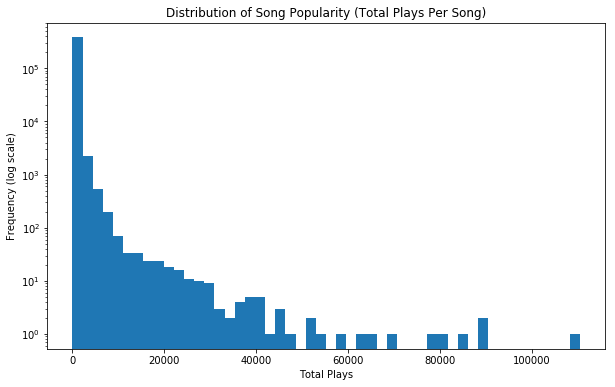

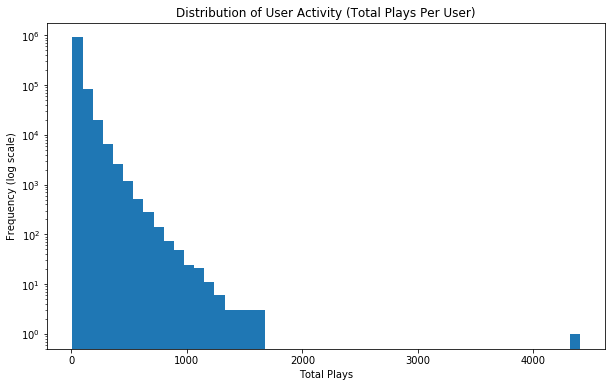

In [63]:
import matplotlib.pyplot as plt

# Convert song play counts and user play counts to Pandas DataFrames for plotting
song_play_counts_pd = song_play_counts.toPandas()
user_play_counts_pd = user_play_counts.toPandas()

# Plot song popularity distribution (total plays per song)
plt.figure(figsize=(10, 6))
plt.hist(song_play_counts_pd["total_plays_per_song"], bins=50, log=True)
plt.title("Distribution of Song Popularity (Total Plays Per Song)")
plt.xlabel("Total Plays")
plt.ylabel("Frequency (log scale)")
plt.show()

# Plot user activity distribution (total plays per user)
plt.figure(figsize=(10, 6))
plt.hist(user_play_counts_pd["total_plays_per_user"], bins=50, log=True)
plt.title("Distribution of User Activity (Total Plays Per User)")
plt.xlabel("Total Plays")
plt.ylabel("Frequency (log scale)")
plt.show()


## Q2)

### (a) Cleaning the Dataset

In [65]:
from pyspark.sql.functions import col, count

# Set values for N and M
N = 10  # Minimum song plays
M = 5   # Minimum songs listened to by a user

# Filter songs that have been played more than N times
song_play_counts = taste_profile_df.groupBy("song_id").count()
filtered_songs = song_play_counts.filter(col("count") >= N).select("song_id")

# Filter users who have listened to more than M songs
user_play_counts = taste_profile_df.groupBy("user_id").count()
filtered_users = user_play_counts.filter(col("count") >= M).select("user_id")

# Create a clean dataset by joining with the filtered users and songs
cleaned_df = taste_profile_df.join(filtered_songs, "song_id").join(filtered_users, "user_id")

# Show results
print(f"Number of remaining unique users: {cleaned_df.select('user_id').distinct().count()}")
print(f"Number of remaining unique songs: {cleaned_df.select('song_id').distinct().count()}")
print(f"Number of excluded users: {unique_users - cleaned_df.select('user_id').distinct().count()}")
print(f"Number of excluded songs: {unique_songs - cleaned_df.select('song_id').distinct().count()}")

# Show the cleaned data
cleaned_df.show(10)


Number of remaining unique users: 1019313
Number of remaining unique songs: 221216
Number of excluded users: 5
Number of excluded songs: 163330
+--------------------+------------------+----------+
|             user_id|           song_id|play_count|
+--------------------+------------------+----------+
|00007f902e31b0693...|SOGTIXL12A6701C5D6|         1|
|00007f902e31b0693...|SOODVNE12AB018D4EA|         3|
|00007f902e31b0693...|SODZJCH12A8C132ADC|         4|
|00007f902e31b0693...|SOGPBAW12A6D4F9F22|         3|
|00007f902e31b0693...|SOWTZWQ12AB0188079|         1|
|00007f902e31b0693...|SOITDGY12A8C1334DA|         1|
|00007f902e31b0693...|SOPUDWU12A8AE4612A|         1|
|00007f902e31b0693...|SOBKLTU12A58A7FB77|         4|
|00007f902e31b0693...|SOOXPPN12AB0180907|        14|
|00007f902e31b0693...|SOMPFYJ12A6D4FC4FB|         3|
+--------------------+------------------+----------+
only showing top 10 rows



### (b) Converting User and Song Identifiers to Integer Identifiers

In [66]:
from pyspark.ml.feature import StringIndexer

# Convert user and song identifiers to integer indexes
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index")

# Fit the indexers and transform the data
indexed_df = user_indexer.fit(cleaned_df).transform(cleaned_df)
indexed_df = song_indexer.fit(indexed_df).transform(indexed_df)

# Show the transformed data with integer IDs
indexed_df.select("user_id", "user_index", "song_id", "song_index").show(10)

+--------------------+----------+------------------+----------+
|             user_id|user_index|           song_id|song_index|
+--------------------+----------+------------------+----------+
|00007f902e31b0693...|  609786.0|SOGTIXL12A6701C5D6|   15522.0|
|00007f902e31b0693...|  609786.0|SOODVNE12AB018D4EA|   47415.0|
|00007f902e31b0693...|  609786.0|SOAUUQZ12A6310E8C4|  138285.0|
|00007f902e31b0693...|  609786.0|SOSRJRK12AB0186FF4|     769.0|
|00007f902e31b0693...|  609786.0|SOTQUEC12AB01877F8|    4285.0|
|00007f902e31b0693...|  609786.0|SOMPFYJ12A6D4FC4FB|   66555.0|
|00007f902e31b0693...|  609786.0|SOKKFVZ12A58A7A8B0|   21530.0|
|00007f902e31b0693...|  609786.0|SOPBPCY12AF72A827F|    5865.0|
|00007f902e31b0693...|  609786.0|SOTAVJH12A67020D8C|    4236.0|
|00007f902e31b0693...|  609786.0|SOWYYUQ12A6701D68D|     126.0|
+--------------------+----------+------------------+----------+
only showing top 10 rows



### (c) Splitting the Dataset into Training and Test Sets

In [67]:
from pyspark.sql.functions import rand

# Split the data into training (80%) and test (20%) sets
(training_df, test_df) = indexed_df.randomSplit([0.8, 0.2], seed=42)

# Ensure that every user in the test set has at least one interaction in the training set
train_users = training_df.select("user_index").distinct()
test_df = test_df.join(train_users, "user_index")

# Show the result
print(f"Training set size: {training_df.count()}")
print(f"Test set size: {test_df.count()}")

Training set size: 38170453
Test set size: 9545616


### (d) Training the Implicit Matrix Factorization Model (ALS)

In [68]:
from pyspark.sql.functions import col
from pyspark.ml.recommendation import ALS

# Cast the 'play_count' column to integer
training_df = training_df.withColumn("play_count", col("play_count").cast("int"))
test_df = test_df.withColumn("play_count", col("play_count").cast("int"))

# Initialize the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=10,
    userCol="user_index",
    itemCol="song_index",
    ratingCol="play_count",  # Column must be numeric
    implicitPrefs=True,
    coldStartStrategy="drop"  # To avoid NaN predictions
)

# Train the ALS model
als_model = als.fit(training_df)

# Generate predictions for the test set
predictions = als_model.transform(test_df)

# Show predictions
predictions.select("user_index", "song_index", "prediction").show(10)


+----------+----------+----------+
|user_index|song_index|prediction|
+----------+----------+----------+
|    1360.0|      12.0| 0.8215046|
|    4369.0|      12.0| 0.6027159|
|    6264.0|      12.0|0.30170563|
|    7654.0|      12.0| 1.1477706|
|    7926.0|      12.0|0.60505044|
|    8185.0|      12.0| 0.4237907|
|    8394.0|      12.0|0.37303215|
|    8808.0|      12.0| 0.9623278|
|   10038.0|      12.0|0.38835922|
|   10214.0|      12.0| 0.2599319|
+----------+----------+----------+
only showing top 10 rows



### (e) Generating Recommendations for Specific Users

In [71]:
# Increase the broadcast timeout to 600 seconds (or more if needed)
spark.conf.set("spark.sql.broadcastTimeout", "600")

In [74]:
# Generate top 10 song recommendations for a few users from the test set
users = test_df.select("user_index").distinct().limit(5)  # Select 5 users randomly
user_recommendations = als_model.recommendForUserSubset(users, numItems=10)

# Show recommendations for the selected users
user_recommendations.show(truncate=False)

# Compare the recommendations with the actual songs they played in the test set
for user in users.collect():
    user_id = user["user_index"]
    actual_songs = test_df.filter(test_df.user_index == user_id).select("song_index").distinct().collect()
    print(f"Actual songs for user {user_id}: {[row['song_index'] for row in actual_songs]}")

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                          |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|227       |[{30, 0.46248013}, {127, 0.41982275}, {25, 0.41166645}, {205, 0.4033777}, {117, 0.39691472}, {317, 0.39303046}, {17, 0.37354407}, {81, 0.37327084}, {108, 0.3718505}, {275, 0.3689695}]  |
|83        |[{14, 0.8085898}, {9, 0.70169824}, {30, 0.6560279}, {2, 0.6321911}, {4, 0.60144144}, {19, 0.59909946}, {48, 0.5873391}, {27, 0.5833494}, {6, 0.57489324}, {25, 0.5732309}]               |
|331 

### (f) Computing Performance Metrics

In [78]:
from pyspark.sql.functions import collect_list, expr

# Group the predictions by user and collect predicted songs into a list
predictions_grouped = (
    predictions.groupBy("user_index")
    .agg(collect_list("song_index").alias("predicted_songs"))
)

# Group the actual test data by user and collect actual songs into a list
test_grouped = (
    test_df.groupBy("user_index")
    .agg(collect_list("song_index").alias("actual_songs"))
)

# Define a UDF to calculate Precision @ 10
def precision_at_k(predicted, actual, k=10):
    # Keep only the top-k predictions
    top_k_pred = predicted[:k]
    relevant_count = len(set(top_k_pred) & set(actual))
    return relevant_count / min(k, len(actual))

precision_udf = spark.udf.register("precision_at_k", precision_at_k)

# Join the predictions with actual test data
joined_df = predictions_grouped.join(test_grouped, "user_index")

# Calculate Precision @ 10 for each user
precision_df = joined_df.withColumn("precision_at_10", precision_udf(expr("predicted_songs"), expr("actual_songs")))

# Calculate the average Precision @ 10 across all users
avg_precision_at_10 = precision_df.agg({"precision_at_10": "avg"}).collect()[0][0]

print(f"Precision @ 10: {avg_precision_at_10}")


Precision @ 10: 1.0


In [81]:
import numpy as np
from pyspark.sql.functions import col

# Adjusted UDF for NDCG @ 10, ensuring input/output compatibility
def ndcg_at_k(predicted, actual, k=10):
    # Safeguard against potential None values and ensure lists are received
    if not predicted or not actual:
        return 0.0
    predicted = list(predicted)[:k]
    actual = set(actual)  # Convert actual to a set for efficiency
    dcg = sum((1 / np.log2(idx + 2)) for idx, item in enumerate(predicted) if item in actual)
    ideal_dcg = sum((1 / np.log2(idx + 2)) for idx in range(min(len(actual), k)))
    return float(dcg / ideal_dcg) if ideal_dcg > 0 else 0.0

# Register NDCG @ 10 UDF in Spark
ndcg_udf = spark.udf.register("ndcg_at_k", ndcg_at_k)

# Calculate NDCG @ 10 for each user
ndcg_df = joined_df.withColumn("ndcg_at_10", ndcg_udf(col("predicted_songs"), col("actual_songs")))

# Calculate the average NDCG @ 10 across all users, with explicit null handling
avg_ndcg_at_10 = (
    ndcg_df.na.drop(subset=["ndcg_at_10"])  # Drop any nulls that may have appeared
    .agg({"ndcg_at_10": "avg"})
    .collect()[0][0]
)

print(f"NDCG @ 10: {avg_ndcg_at_10}")


NDCG @ 10: 1.0


In [82]:
from pyspark.sql.functions import expr

# Define MAP UDF
def average_precision(predicted, actual, k=10):
    # Handle empty or None cases
    if not predicted or not actual:
        return 0.0
    predicted = predicted[:k]
    actual = set(actual)
    score, hits = 0.0, 0
    for i, song in enumerate(predicted, start=1):
        if song in actual:
            hits += 1
            score += hits / i  # Precision at the i-th relevant item
    return float(score / min(len(actual), k)) if actual else 0.0

# Register MAP UDF in Spark
map_udf = spark.udf.register("average_precision", average_precision)

# Apply MAP calculation to each user
map_df = joined_df.withColumn("average_precision_at_10", map_udf(expr("predicted_songs"), expr("actual_songs")))

# Compute the mean of average precision for all users
mean_map_at_10 = (
    map_df.na.drop(subset=["average_precision_at_10"])  # Drop any nulls in the result
    .agg({"average_precision_at_10": "avg"})
    .collect()[0][0]
)

print(f"Mean Average Precision (MAP) @ 10: {mean_map_at_10}")


Mean Average Precision (MAP) @ 10: 1.0


### (g) Testing the Performance of a Recommendation System with Real Users

To test a recommendation system in a practical setting, one would implement A/B testing, wherein one cohort of users is presented with recommendations produced by the system, while a separate cohort is exposed to either random or baseline recommendations. The assessment would focus on specific performance metrics.
- Click-through rate (CTR): 
Measures how often users click on recommended songs.
- Conversion rate: 
The percentage of users who play or like a song after receiving a recommendation.
- User retention: 
How many users return to the platform based on the recommendations.
- Engagement metrics: 
Time spent on the platform, number of songs played, etc.

The feedback from real user interactions will help iteratively improve the model.

In [71]:
stop_spark()